# LSTM & Word Embeddings for Sentiment Classification

### Loading Libraries

In [36]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Warning
import warnings

# Path
from pathlib import Path

# Scikit-Learn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_absolute_error

# TensorFlow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [38]:
np.random.seed(42)

idx = pd.IndexSlice

sns.set_style('whitegrid')

In [40]:
%matplotlib inline

In [42]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


### Loading Reviews

In [45]:
vocab_size = 20000

In [47]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, 
                                                      skip_top=0,
                                                      maxlen=None, 
                                                      oov_char=2, 
                                                      index_from=3,
                                                      num_words=vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


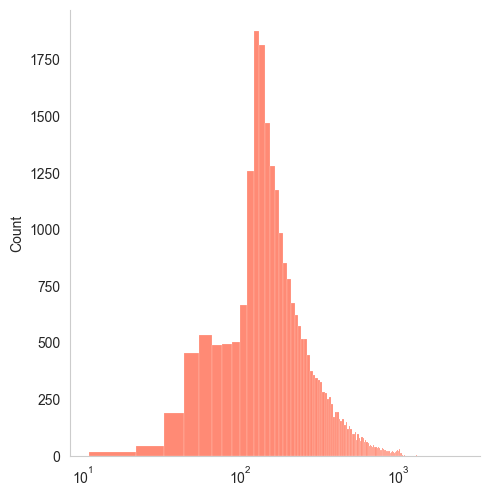

In [51]:
ax = sns.displot([len(review) for review in X_train], color='tomato')
ax.set(xscale='log');
plt.grid()
plt.show()

### Preparing Data

In [54]:
maxlen = 100

In [56]:
X_train_padded = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test_padded = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [58]:
X_train_padded.shape, X_test_padded.shape

((25000, 100), (25000, 100))

### Defining Model Architecture

In [61]:
K.clear_session()

#### Custom Loss Metric

In [64]:
embedding_size = 100

In [66]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim= embedding_size, 
              input_length=maxlen),
    GRU(units=32,  
        dropout=0.2, # comment out to use optimized GPU implementation
        recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

rnn.summary()

/opt/anaconda3/envs/MLAT/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-04 08:36:24.867929: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-04 08:36:24.867975: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-04 08:36:24.867984: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-04 08:36:24.868014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-04 08:36:24.868038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='RMSProp', 
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [74]:
# rnn_path = (results_path / 'lstm.h5').as_posix()

# checkpointer = ModelCheckpoint(filepath=rnn_path,
#                                verbose=1,
#                                monitor='val_AUC',
#                                mode='max',
#                                save_best_only=True)

In [72]:
early_stopping = EarlyStopping(monitor='val_AUC', 
                               mode='max',
                              patience=5,
                              restore_best_weights=True)

In [ ]:
training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/100


2025-05-04 08:37:12.039852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 51/782 ━━━━━━━━━━━━━━━━━━━━ 1:57:35 10s/step - AUC: 0.5307 - accuracy: 0.5177 - loss: 0.6917

#### Evaluating Results

In [ ]:
history = pd.DataFrame(training.history)

history.index += 1

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))

df1 = (history[['accuracy', 'val_accuracy']]
       .rename(columns={'accuracy': 'Training',
                        'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(history)))

axes[0].axvline(df1.Validation.idxmax(), ls='--', lw=1, c='k')

df2 = (history[['AUC', 'val_AUC']]
       .rename(columns={'AUC': 'Training',
                        'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(history)))

axes[1].axvline(df2.Validation.idxmax(), ls='--', lw=1, c='k')

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_imdb_cv', dpi=300)
plt.grid()
plt.show()

In [ ]:
y_score = rnn.predict(X_test_padded)
y_score.shape

In [ ]:
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)